In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
df=pd.read_csv('../../Database/DB_v2.csv',index_col=False)
df=df.drop(['Unnamed: 0'],axis=1)
scaler=StandardScaler()


In [3]:
y=df['DEF_PAY']
X=scaler.fit_transform(df.drop(['DEF_PAY'],axis=1))

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
import joblib

In [5]:
def gridSearch(model,params,X,Y,VALID_SIZE,FOLDS=10):
    skf = StratifiedKFold(n_splits=FOLDS)
    scoring = {'AUC': 'roc_auc', 'Accuracy':'accuracy'}    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=VALID_SIZE, shuffle=True)
    class_weightsTrain = class_weight.compute_class_weight('balanced',np.unique(Y_train),Y_train)
    gs = GridSearchCV(model, scoring=scoring,cv=skf, param_grid=params, return_train_score=True, n_jobs=-1,refit='AUC')
    gs.fit(X_train, Y_train)
    print(gs.best_estimator_)
    print(np.abs(gs.best_score_))
    return gs,X_test,Y_test

Instancia del modelo, diccionario de hiperparámetros y métricas de validación

In [12]:
param_grid = {
    'reg_param': (0.00001, 0.0001, 0.001,0.01, 0.1,0.15,0.2,0.3,0.4,0.5,0.7), 
    'tol': (0.0001, 0.001,0.01, 0.1), 
                   }
clf = QuadraticDiscriminantAnalysis()
gs,_,_=gridSearch(clf,param_grid,X,y,0.2)
joblib.dump(gs, 'gs_discriminante.pkl') #se guarda el gs para su posterior uso

/home/sht/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=3327     1
27827    0
18107    0
8743     0
4643     0
        ..
1041     1
29507    0
14408    0
7920     1
27792    0
Name: DEF_PAY, Length: 24000, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


QuadraticDiscriminantAnalysis(reg_param=0.7)
0.7503357050053261


/home/sht/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


['gs_discriminante.pkl']

In [13]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
import scikitplot as skplt#Esta librería toca instalarla "conda install -c conda-forge scikit-plot"
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE 

def experimentar(X,Y,oversampling=False):

    #Validamos el modelo
    Folds = 10
    skf = StratifiedKFold(n_splits=Folds)
    resultados = pd.DataFrame()
    idx = 0
    Acc = []
    Auc= []

    for j, (train, test) in enumerate(skf.split(X, Y)):
        Xtrain= X[train,:]
        Ytrain = Y[train]
        Xtest = X[test, :]
        Ytest = Y[test]
        #Normalizamos los datos
        scaler = StandardScaler().fit(X= Xtrain)       
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        model = QuadraticDiscriminantAnalysis(priors=None, reg_param=0.7, store_covariance=True,
                              tol=0.0001)
        if oversampling:
            sm = SMOTE(random_state=42)
            Xtrain, Ytrain = sm.fit_resample(Xtrain, Ytrain)
            
        model.fit(X=Xtrain, y=Ytrain)
        Yest = model.predict_proba(Xtest)
        
        Acc.append(balanced_accuracy_score(Ytest,np.argmax(Yest, 1)))
        aux=roc_auc_score(Ytest,Yest[:,1])
        Auc.append(aux)
    skplt.metrics.plot_confusion_matrix(Ytest,np.argmax(Yest, 1),normalize=True) #matriz de confusión
    skplt.metrics.plot_roc(Ytest,Yest)
    print(classification_report(Ytest,np.argmax(Yest, 1)))
    
    resultados.loc[idx,'AUC medio'] = np.mean(Auc)
    resultados.loc[idx,'AUC intervalo de confianza'] = np.std(Auc)
    resultados.loc[idx,'Accuracy medio'] = np.mean(Acc)
    resultados.loc[idx,'Accuracy intervalo de confianza'] = np.std(Acc)
    return (resultados)

/home/sht/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/sht/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/sht/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/sht/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/sht/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/sht/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/hom

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      2337
           1       0.56      0.50      0.53       663

    accuracy                           0.80      3000
   macro avg       0.71      0.70      0.70      3000
weighted avg       0.80      0.80      0.80      3000



/home/sht/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,AUC medio,AUC intervalo de confianza,Accuracy medio,Accuracy intervalo de confianza
0,0.750552,0.022238,0.686759,0.020097


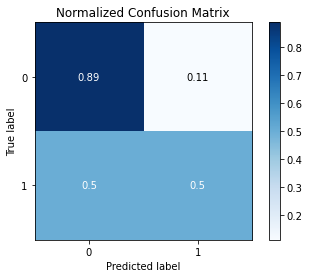

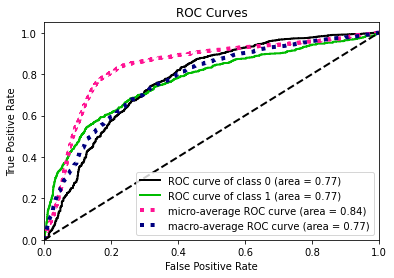

In [14]:
experimentar(X,y,False)

/home/sht/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/sht/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/sht/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/sht/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/sht/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/sht/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/hom

              precision    recall  f1-score   support

           0       0.89      0.73      0.81      2337
           1       0.42      0.68      0.52       663

    accuracy                           0.72      3000
   macro avg       0.66      0.71      0.66      3000
weighted avg       0.79      0.72      0.74      3000



/home/sht/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,AUC medio,AUC intervalo de confianza,Accuracy medio,Accuracy intervalo de confianza
0,0.747692,0.022371,0.693352,0.021174


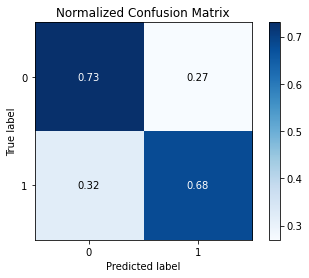

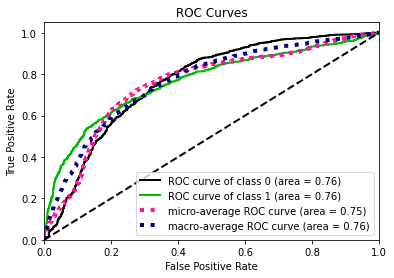

In [15]:
experimentar(X,y,oversampling=True)